In [10]:
from zipfile import ZipFile
file_name="PlantVillage.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [11]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [12]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [13]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
len(dataset)#each one contain 32 images

68

In [17]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)#3:RGB
    print(label_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[1 0 0 1 0 1 2 0 2 1 1 1 1 0 1 0 0 1 1 2 1 1 0 0 0 0 0 2 0 0 1 0]
(256, 256, 3)


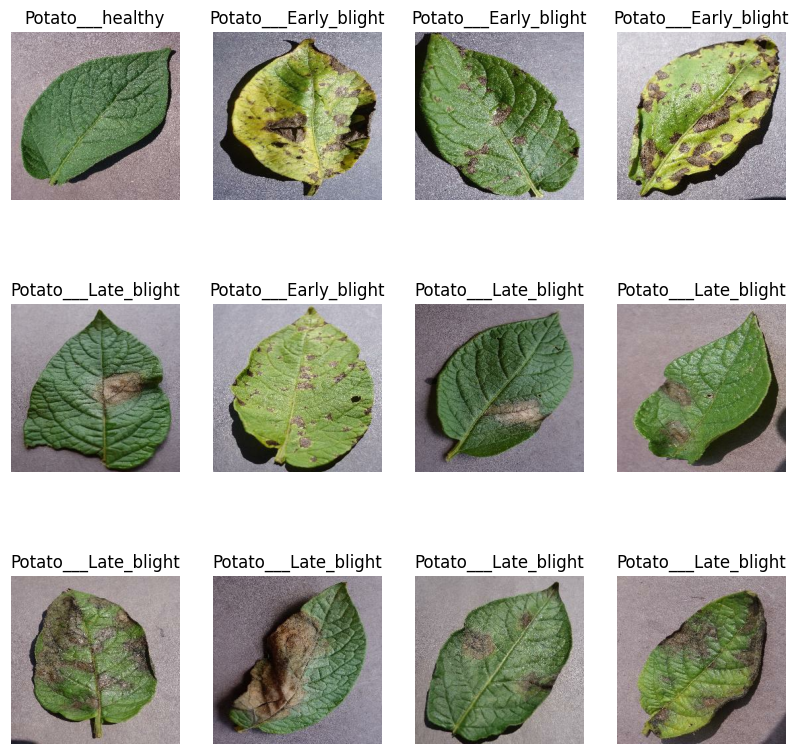

In [18]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [19]:
# 80%==>training
# 10%==>validation
# 10%==> test
# run 50 epochs on training and validation dataa then test it.

In [20]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [21]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

54

In [23]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
#Data Augmentation:Basically use to mave our model robust(also predict on contrast,horizontal flip,Rotatedetc)
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
n_classes=3
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),# Conv. layer
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
   optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history=model.fit(
train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 22s 113ms/step - loss: 0.8890 - accuracy: 0.5006 - val_loss: 0.7520 - val_accuracy: 0.5990
Epoch 2/50
54/54 [==============================] - 3s 59ms/step - loss: 0.5583 - accuracy: 0.7419 - val_loss: 1.4105 - val_accuracy: 0.6823
Epoch 3/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3094 - accuracy: 0.8756 - val_loss: 0.1963 - val_accuracy: 0.9271
Epoch 4/50
54/54 [==============================] - 3s 59ms/step - loss: 0.2128 - accuracy: 0.9190 - val_loss: 0.1869 - val_accuracy: 0.9479
Epoch 5/50
54/54 [==============================] - 3s 60ms/step - loss: 0.1699 - accuracy: 0.9392 - val_loss: 0.1925 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 3s 59ms/step - loss: 0.0942 - accuracy: 0.9630 - val_loss: 0.1002 - val_accuracy: 0.9583
Epoch 7/50
54/54 [==============================] - 3s 58ms/step - loss: 0.1448 - accuracy: 0.9502 - val_loss: 0.1257 - val_accuracy: 0.9479
Epoch 8/50


In [30]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 2s 28ms/step - loss: 0.2400 - accuracy: 0.9453


In [31]:
scores

[0.23995786905288696, 0.9453125]

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history['accuracy']

[0.5005787014961243,
 0.7418981194496155,
 0.8755787014961243,
 0.9189814925193787,
 0.9392361044883728,
 0.9629629850387573,
 0.9502314925193787,
 0.9820601940155029,
 0.9664351940155029,
 0.9658564925193787,
 0.9849537014961243,
 0.9670138955116272,
 0.9768518805503845,
 0.9809027910232544,
 0.9907407164573669,
 0.9942129850387573,
 0.9942129850387573,
 0.9768518805503845,
 0.9780092835426331,
 0.9791666865348816,
 0.9728009104728699,
 0.9878472089767456,
 0.9942129850387573,
 0.9942129850387573,
 0.9849537014961243,
 0.9832175970077515,
 0.9930555820465088,
 0.9965277910232544,
 0.9884259104728699,
 0.9959490895271301,
 0.9971064925193787,
 0.9942129850387573,
 0.9924768805503845,
 0.9884259104728699,
 0.9976851940155029,
 1.0,
 1.0,
 0.9994212985038757,
 0.9936342835426331,
 0.9826388955116272,
 0.9953703880310059,
 0.9953703880310059,
 0.9878472089767456,
 0.9907407164573669,
 0.9947916865348816,
 0.9994212985038757,
 0.9965277910232544,
 0.9994212985038757,
 0.9994212985038757,
 

In [35]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

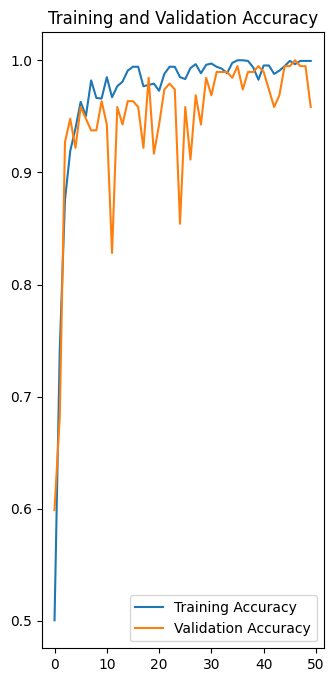

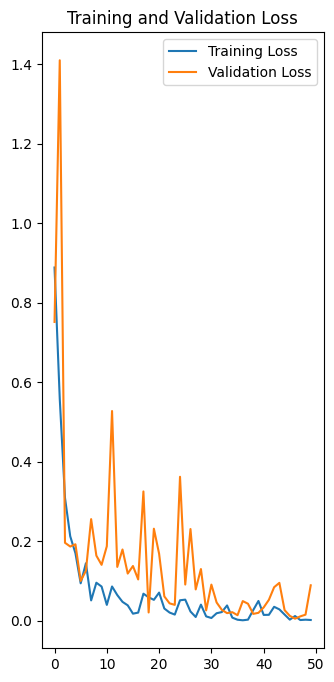

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

first image to predict
first image's actual label: Potato___healthy
1/1 [==============================] - 0s 207ms/step
Potato___Late_blight


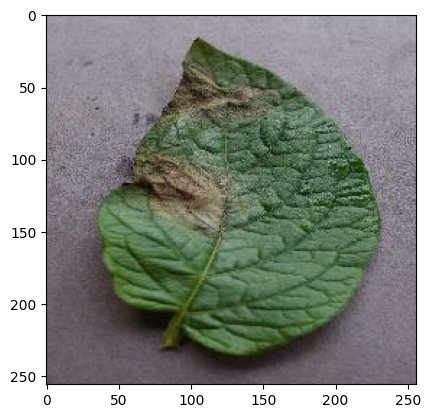

In [37]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    batch_prediction= model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)#Create a batch

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 27ms/step


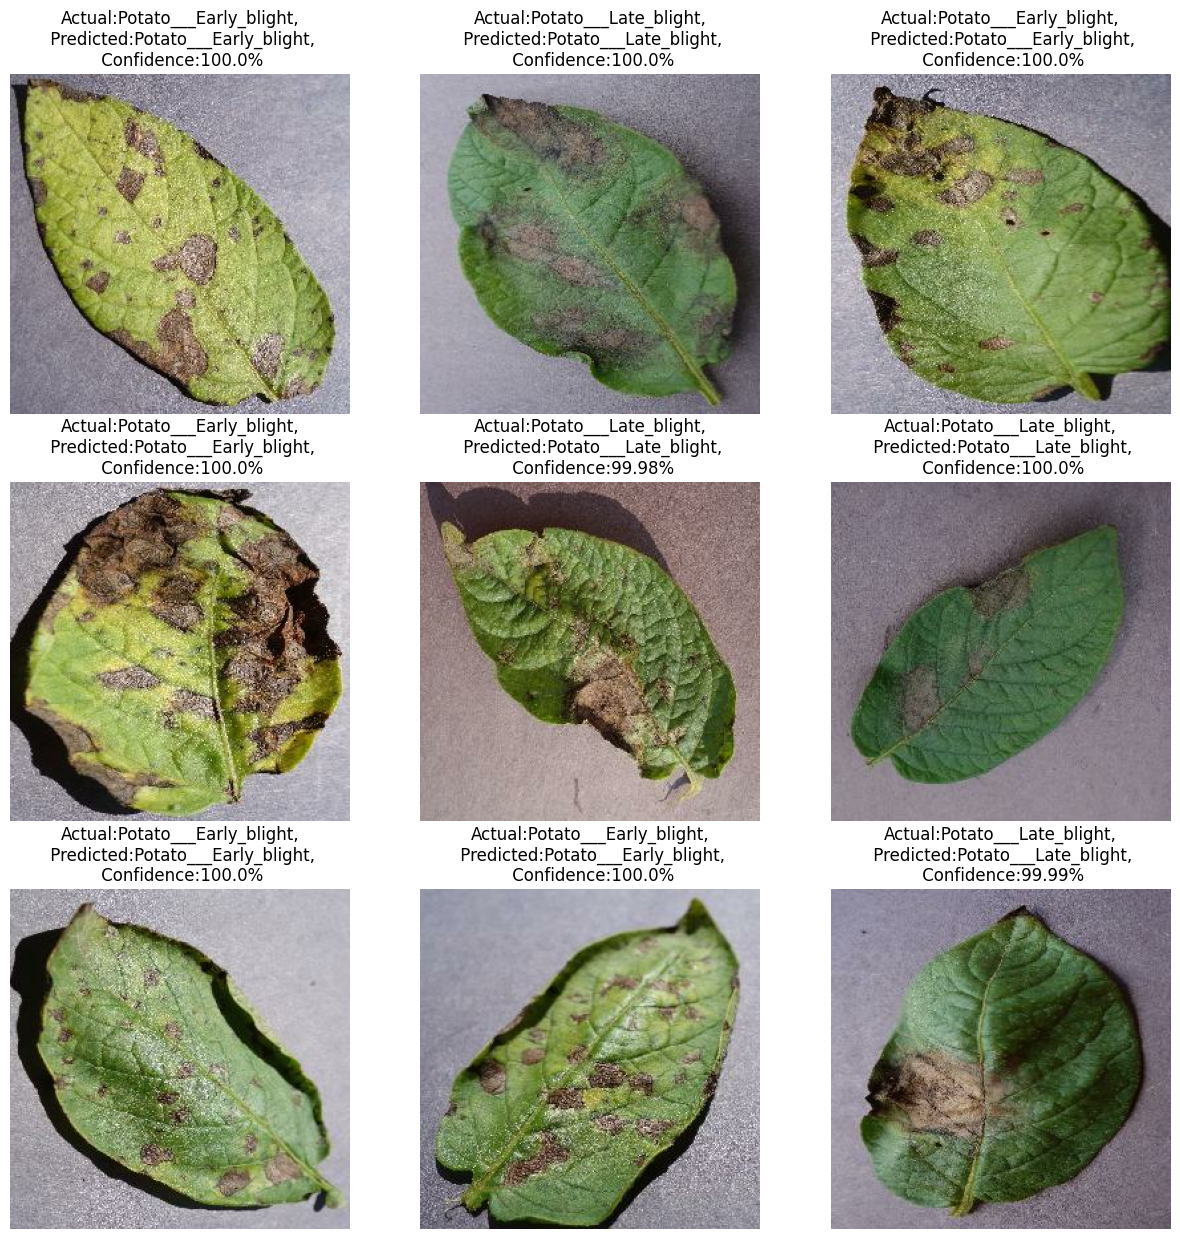

In [39]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class= class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}%")

    plt.axis("off")

In [40]:
#model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
#model.save('my_model.keras')

In [42]:
#from tensorflow.keras.models import load_model
#model.save('/content/drive/MyDrive/Saved model/model1.hdf5')

In [43]:
model.save("/content/drive/MyDrive/Model_save")